# Setup



In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
# change to your workspace
%cd /content/drive/MyDrive/DSBA
%ls

/content/drive/MyDrive/DSBA
data/  Model1.ipynb  Model2.ipynb


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib inline

# Read Data

In [ ]:
data_dir = 'data'

In [ ]:
# read weather dataframe
data_path = data_dir + '/weather_nyc_20170101_to_20211031.csv'
df_weat = pd.read_csv(data_path)
df_weat.columns = df_weat.columns.str.lower()
df_weat.date = pd.to_datetime(df_weat.date)

The citibike data zip files sometimes include a `__MACOSX` file, \@\_\@

So we could download those months' data and unzip by ourselves

These files includes:

- 02/2019 & 09/2019
- 06/2020 & 11/2020
- 02/2021 - 10/2021

In [ ]:
def read_data(year, months, data_dir, local=False):
    data = []

    for month in months:
        try:
            if local:
                raise ValueError
            data_path = 'https://s3.amazonaws.com/tripdata/%s%s-citibike-tripdata.csv.zip' % (str(year), str(month).zfill(2))
            df = pd.read_csv(data_path)
            print('\r', data_path, 'done', end='')
        except ValueError:
            data_path = '%s/%s%s-citibike-tripdata.csv' % (data_dir, str(year), str(month).zfill(2))
            df = pd.read_csv(data_path)
            print('\r', data_path, 'done', end='')
        
        df = preprocess(df)
        data.append(df)

    data = pd.concat(data)
    data.reset_index(drop=True, inplace=True)

    return data
    

In [ ]:
# preprocess pipeline
def preprocess(df):
    # rename columns
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.rename(columns={'started_at': 'start_time',
                       'starttime': 'start_time',
                       'start_station_latitude': 'start_lat',
                       'start_station_longitude': 'start_lng'},
              inplace=True)
    # select useful columns
    df = df[['start_time', 'start_station_name', 'start_lat', 'start_lng']].dropna()
    # change datatype of started_at to datetime
    df.start_time = pd.to_datetime(df.start_time)
    df['date'] = pd.to_datetime(df.start_time.dt.date)
    # count number of rides originate at each station for each day
    df = df.groupby(by=['date', 'start_station_name']).agg(
        {'start_time': 'count', 'start_lat': 'mean', 'start_lng': 'mean'})
    df.reset_index(inplace=True)
    df.rename(columns={'start_time': 'nrides'}, inplace=True)

    return df


In [ ]:
# around 10 min (it depends on the network)
# if you have downloaded every dataset on local device, then turn parameter local to True 
data17 = read_data(2017, np.arange(1, 13), data_dir, local=False)
data18 = read_data(2018, np.arange(1, 13), data_dir, local=False)
data19 = read_data(2019, np.arange(1, 13), data_dir, local=False)
data20 = read_data(2020, np.arange(1, 13), data_dir, local=False)
data21 = read_data(2021, np.arange(1, 11), data_dir, local=False)

 data/202110-citibike-tripdata.csv done

In [ ]:
# or read existing dataset
data17 = pd.read_pickle(data_dir + '/data17.pkl')
data18 = pd.read_pickle(data_dir + '/data18.pkl')
data19 = pd.read_pickle(data_dir + '/data19.pkl')
data20 = pd.read_pickle(data_dir + '/data20.pkl')
data21 = pd.read_pickle(data_dir + '/data21.pkl')

In [ ]:
import pickle
# save the raw dataset so that we do not need to spend another 10 min next time
data17.to_pickle(data_dir + '/data17.pkl')
data18.to_pickle(data_dir + '/data18.pkl')
data19.to_pickle(data_dir + '/data19.pkl')
data20.to_pickle(data_dir + '/data20.pkl')
data21.to_pickle(data_dir + '/data21.pkl')

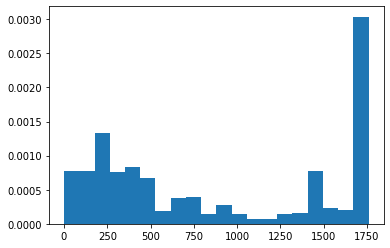

In [ ]:
# this figure shows the distribution of available days for each station
# personally I prefer more constant features (higher frequency)
data = pd.concat([data17, data18, data19, data20, data21])
data.reset_index(drop=True, inplace=True)

st_info = data[['start_station_name']].value_counts()
st_info = pd.DataFrame(st_info).reset_index()
st_info.rename(columns={0: 'freq'}, inplace=True)

plt.figure()
plt.hist(st_info.freq, bins=20, density=True)
plt.show()

In [ ]:
# select top 500 stations, which provide data more constantly
st_info = st_info.iloc[0:500]

In [ ]:
# get station location, and add location features
geo_info = data.groupby(by=['start_station_name']).agg(
    {'start_lat': 'mean', 'start_lng': 'mean'}).reset_index()
st_info = pd.merge(st_info, geo_info, how='left', on='start_station_name')

# is_proximate
# if distance to Penn Station < 0.5 mile or distance to Grand Central Station < 0.5 mile then 1 else 0
from geopy import distance

PennSt = (40.751366, -73.990179) # Penn Station
GrandCentralSt = (40.752998, -73.977266) # Grand Central Station

st_info['d_Penn'] = st_info.apply(lambda x: distance.vincenty((x.start_lat, x.start_lng), PennSt).mi, axis=1)
st_info['d_GrandCentral'] = st_info.apply(lambda x: distance.vincenty((x.start_lat, x.start_lng), GrandCentralSt).mi, axis=1)

st_info['is_proximate'] = 1 * ((st_info.d_Penn < 0.5) | (st_info.d_GrandCentral < 0.5))

In [ ]:
st_info

,start_station_name,freq,start_lat,start_lng,d_Penn,d_GrandCentral,is_proximate
0,Metropolitan Ave & Meeker Ave,1760,40.714133,-73.952344,3.247251,2.983816,0
1,Avenue D & E 3 St,1760,40.720828,-73.977932,2.203049,2.220065,0
2,11 Ave & W 41 St,1760,40.760301,-73.998842,0.765995,1.239210,0
3,E 27 St & 1 Ave,1760,40.739445,-73.976806,1.081286,0.935504,0
4,Cleveland Pl & Spring St,1759,40.722104,-73.997249,2.052988,2.375826,0
...,...,...,...,...,...,...,...
495,Fulton St & William St,1583,40.709563,-74.006537,3.009606,3.368015,0
496,Broadway & W 60 St,1579,40.769155,-73.981918,1.301766,1.141292,0
497,Broadway & W 53 St,1578,40.763441,-73.982681,0.921389,0.774565,0
498,E 82 St & East End Ave,1561,40.772461,-73.946821,2.700700,2.086890,0


In [ ]:
# cartesian product of dates (01/01/2017 - 10/31/2021) and stations (selected top 500)
index = pd.MultiIndex.from_product([df_weat.date, st_info.start_station_name],
                                   names=['date', 'start_station_name'])
date_st = pd.DataFrame(index = index).reset_index()

# complete those missing data
# sometimes, a station may need to be maintained, then its data on that day is missed
# fill those missing nrides with the mean value of all stations that year
def complete_data(year, data, date_st):
    cond1 = date_st.date >= pd.Timestamp(year=year, month=1, day=1)
    cond2 = date_st.date < pd.Timestamp(year=year+1, month=1, day=1)
    data = pd.merge(data, date_st[cond1 & cond2], how='right')
    data.fillna(value={'nrides': int(data.nrides.mean())}, inplace=True)
    return data

In [ ]:
data17 = complete_data(2017, data17, date_st)
data18 = complete_data(2018, data18, date_st)
data19 = complete_data(2019, data19, date_st)
data20 = complete_data(2020, data20, date_st)
data21 = complete_data(2021, data21, date_st)

In [ ]:
date_info = df_weat[['date']]
# day of week
# Mon: 0, Tue: 1, ... , Sun: 6
date_info['day_of_week'] = date_info.date.dt.dayofweek
# is weekend
date_info['is_weekend'] = 1 * (date_info.day_of_week >= 5)
# weather
# tmax: max temperature
# tmin: min temperature
# prcp: precipitation
# is_rain: prcp > 0
# snwd: snow depth
# snow: snowfall
# is_snow: snwd > 0 or snow > 0
# awnd: average wind speed
date_info = pd.merge(date_info, 
                     df_weat[['date', 'tmax', 'tmin', 'prcp', 'snow', 'snwd', 'awnd']], 
                     on='date', 
                     how='left')
date_info['is_rain'] = 1 * (date_info.prcp > 0)
date_info['is_snow'] = 1 * ((date_info.snow > 0) | (date_info.snwd > 0))
date_info.fillna(value={'awnd': int(date_info.awnd.mean())}, inplace=True)
# season
date_info['is_spring'] = 1 * ((date_info.date.dt.month >= 3) & (date_info.date.dt.month <= 5))
date_info['is_summer'] = 1 * ((date_info.date.dt.month >= 6) & (date_info.date.dt.month <= 8))
date_info['is_autumn'] = 1 * ((date_info.date.dt.month >= 9) & (date_info.date.dt.month <= 11))
date_info['is_winter'] = 1 * ((date_info.date.dt.month == 12) | (date_info.date.dt.month <= 2))
# is_holiday
import holidays

holiday_list = []

for year in {2017, 2018, 2019, 2020, 2021}:
    holiday_list += list(holidays.UnitedStates(years=year).keys())

date_info['is_holiday'] = 1 * date_info.date.apply(lambda x: x in holiday_list)

In [ ]:
date_st

,date,start_station_name
0,2017-01-01,Metropolitan Ave & Meeker Ave
1,2017-01-01,Avenue D & E 3 St
2,2017-01-01,11 Ave & W 41 St
3,2017-01-01,E 27 St & 1 Ave
4,2017-01-01,Cleveland Pl & Spring St
...,...,...
882495,2021-10-31,Fulton St & William St
882496,2021-10-31,Broadway & W 60 St
882497,2021-10-31,Broadway & W 53 St
882498,2021-10-31,E 82 St & East End Ave


In [ ]:
# combine nrides, with station features (geo features) and date features (week of day, weather, ...)
def combine_date(data, st_info, date_info):
    data = pd.merge(data[['date', 'start_station_name', 'nrides']],
                    st_info[['start_station_name', 'd_Penn', 'd_GrandCentral', 'is_proximate']],
                    on='start_station_name',
                    how='left')
    data = pd.merge(data,
                    date_info,
                    on='date',
                    how='left')
    
    return data

In [ ]:
data17 = combine_date(data17, st_info, date_info)
data18 = combine_date(data18, st_info, date_info)
data19 = combine_date(data19, st_info, date_info)
data20 = combine_date(data20, st_info, date_info)
data21 = combine_date(data21, st_info, date_info)

In [ ]:
data21.head()

,date,start_station_name,nrides,d_Penn,d_GrandCentral,is_proximate,day_of_week,is_weekend,tmax,tmin,prcp,snow,snwd,awnd,is_rain,is_snow,is_spring,is_summer,is_autumn,is_winter,is_holiday
0,2021-01-01,Metropolitan Ave & Meeker Ave,15.0,3.247251,2.983816,0,4,0,40,33,0.62,0.0,0.0,5.59,1,0,0,0,0,1,1
1,2021-01-01,Avenue D & E 3 St,30.0,2.203049,2.220065,0,4,0,40,33,0.62,0.0,0.0,5.59,1,0,0,0,0,1,1
2,2021-01-01,11 Ave & W 41 St,58.0,0.765995,1.239210,0,4,0,40,33,0.62,0.0,0.0,5.59,1,0,0,0,0,1,1
3,2021-01-01,E 27 St & 1 Ave,43.0,1.081286,0.935504,0,4,0,40,33,0.62,0.0,0.0,5.59,1,0,0,0,0,1,1
4,2021-01-01,Cleveland Pl & Spring St,45.0,2.052988,2.375826,0,4,0,40,33,0.62,0.0,0.0,5.59,1,0,0,0,0,1,1


# Select Features

In [ ]:
# date_feat_cols: [day_of_week, is_weekend, tmax, tmin, prcp, snow, snwd, awnd, is_rain, is_snow,
#                  is_spring, is_summer, is_autumn, is_winter, is_holiday]
date_feat_cols = date_info.columns.to_list()

def generate_xy(data):
    # date_info: from 01/01/2017 to 10/31/2021
    # this_date_info: only this year, eg. data20 -> year 2020
    this_date_info = data[date_feat_cols].drop_duplicates(ignore_index=True)
    X = []

    for i in range(this_date_info.shape[0]-1):
        # (0 - 14) today weather
        feat1 = this_date_info.loc[i, this_date_info.columns!='date'].to_numpy()
        # (15 - 29) tomorrow weather
        feat2 = this_date_info.loc[i+1, this_date_info.columns!='date'].to_numpy() # next day
        # (30 - 2029) today 500 stations * 4 features
        feat3 = data.loc[data.date == this_date_info.loc[0, 'date'], 
                         ~data.columns.isin(date_feat_cols + ['start_station_name'])].to_numpy().flatten()
        # concatenate features
        X.append(np.concatenate([feat1, feat2, feat3]))
    
    X = pd.DataFrame(X)

    y = data[data.is_proximate == 1].groupby(by=['date']).agg({'nrides': 'sum'})
    y = y.iloc[1:, :].to_numpy().ravel()

    return X, y

In [ ]:
X17, y17 = generate_xy(data17)
X18, y18 = generate_xy(data18)
X19, y19 = generate_xy(data19)
X20, y20 = generate_xy(data20)
X21, y21 = generate_xy(data21)

In [ ]:
# import pickle

# data_path = 'data.pkl'

# data.to_pickle(data_path)

# data = pd.read_pickle(data_path)

# Define train process

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

def train_evaluate(model, X_train, y_train, X_test, y_test, t_test):
    # split the datasets into train set and valiation (dev) set
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25)
    # train the model with the train set
    model.fit(X_train, y_train)
    # see how the model performs on the validation set
    y_dev_pred = model.predict(X_dev)
    # print out how well the model performs on the validation set (mape and r2)
    print('dev mape: %.2f, r2: %.2f' % 
          (mean_absolute_percentage_error(y_dev, y_dev_pred), r2_score(y_dev, y_dev_pred)))
    # see how the model performs on the test set
    y_test_pred = model.predict(X_test)
    # print out how well the model performs on the test set (mape and r2)
    print('test mape: %.2f, r2: %.2f' % 
          (mean_absolute_percentage_error(y_test, y_test_pred), r2_score(y_test, y_test_pred)))
    # plot the how well the model performs on the test set
    plt.figure(figsize=[16, 8])
    plt.plot(t_test, y_test_pred, label='pred')
    plt.plot(t_test, y_test, label='true')
    plt.legend()
    plt.show()
    

# Random Forest Model

dev mape: 0.14, r2: 0.90
test mape: 0.19, r2: 0.79


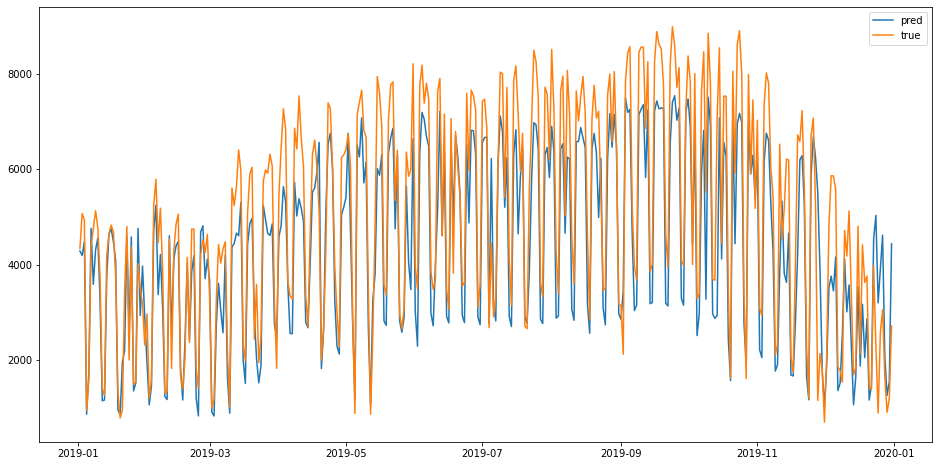

In [ ]:
X = pd.concat([X17, X18])
y = np.concatenate([y17, y18])

# initialize the model with default parameters
model = RandomForestRegressor()
train_evaluate(model, X, y, X19, y19, data19.date.drop_duplicates().to_numpy()[1:])

dev mape: 0.20, r2: 0.89
test mape: 1.04, r2: -2.01


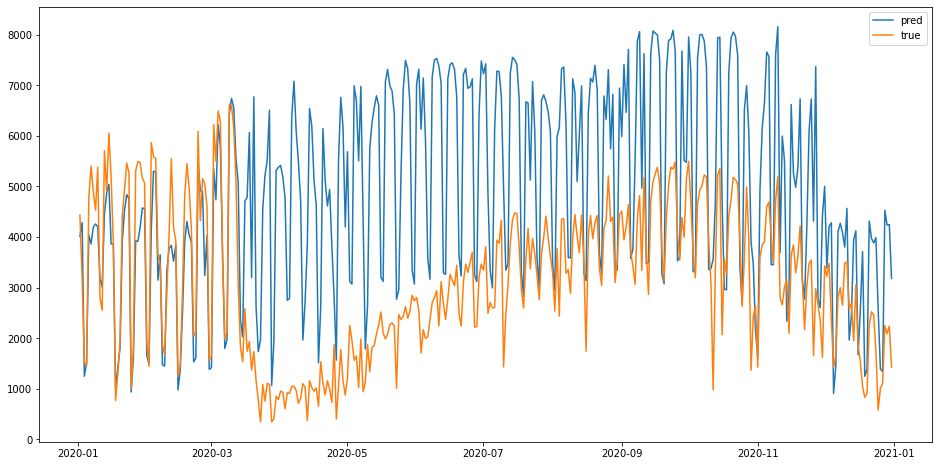

In [ ]:
X = pd.concat([X18, X19])
y = np.concatenate([y18, y19])

model = RandomForestRegressor()
train_evaluate(model, X, y, X20, y20, data20.date.drop_duplicates().to_numpy()[1:])

dev mape: 0.29, r2: 0.76
test mape: 0.28, r2: 0.70


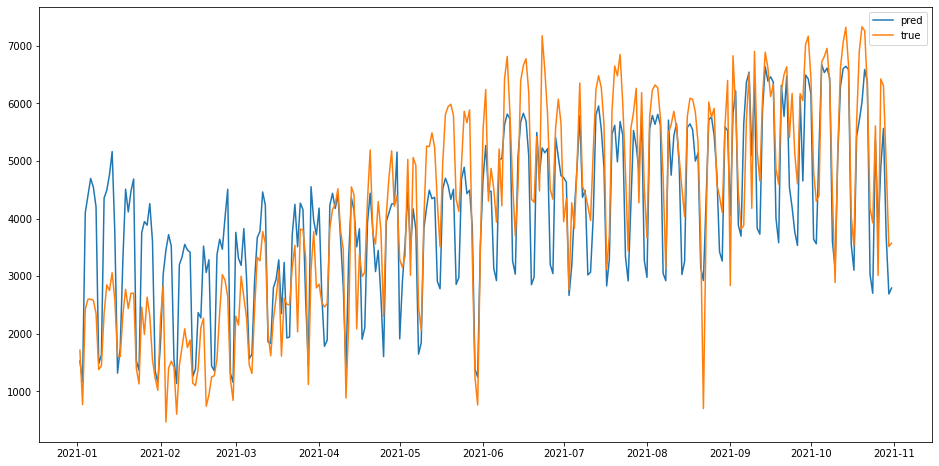

In [ ]:
X = pd.concat([X19, X20])
y = np.concatenate([y19, y20])

model = RandomForestRegressor()
train_evaluate(model, X, y, X21, y21, data21.date.drop_duplicates().to_numpy()[1:])

# Linear Model

dev mape: 0.35, r2: 0.82
test mape: 0.19, r2: 0.80


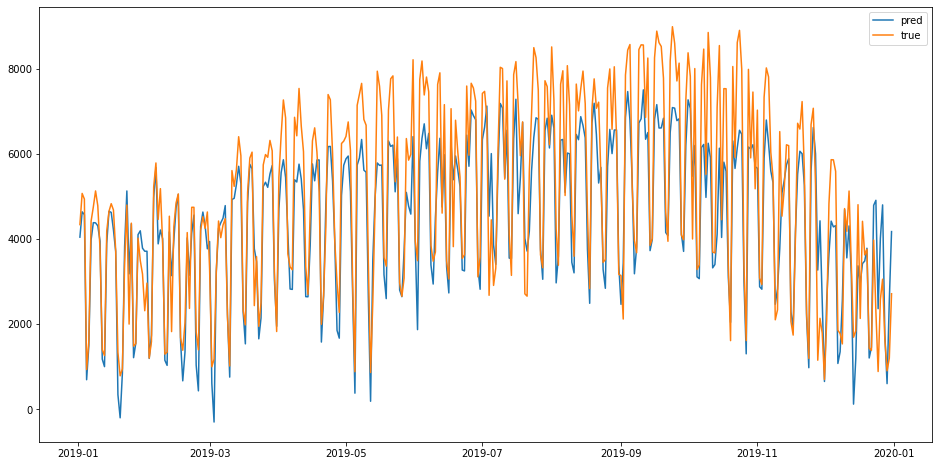

In [ ]:
from sklearn.linear_model import LinearRegression

X = pd.concat([X17, X18])
y = np.concatenate([y17, y18])

model = LinearRegression()
train_evaluate(model, X, y, X19, y19, data19.date.drop_duplicates().to_numpy()[1:])

dev mape: 0.23, r2: 0.84
test mape: 1.03, r2: -1.83


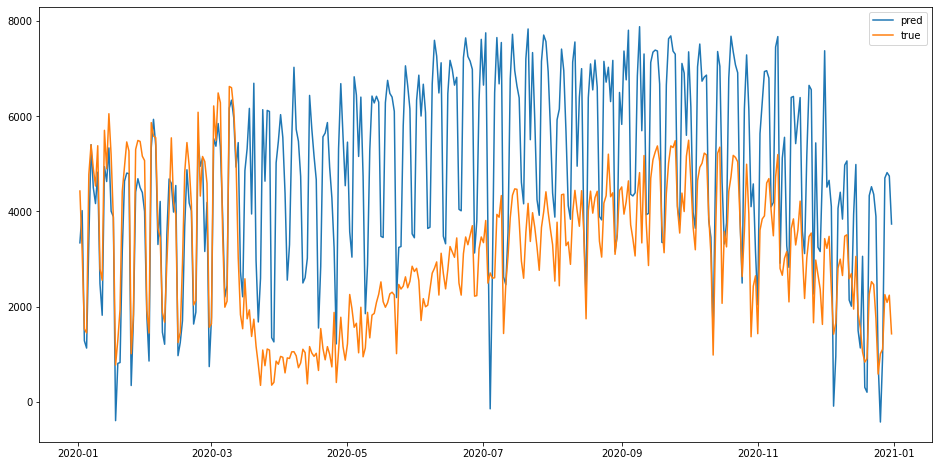

In [ ]:
X = pd.concat([X18, X19])
y = np.concatenate([y18, y19])

model = LinearRegression()
train_evaluate(model, X, y, X20, y20, data20.date.drop_duplicates().to_numpy()[1:])

dev mape: 0.42, r2: 0.67
test mape: 0.34, r2: 0.41


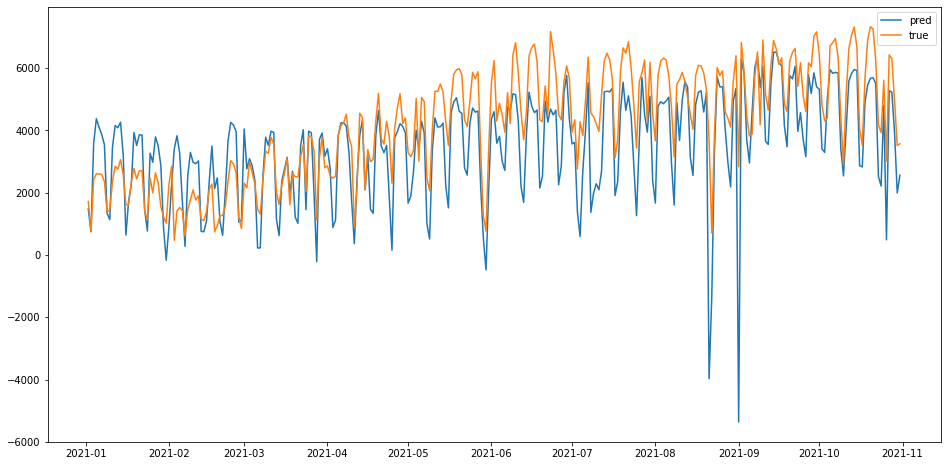

In [ ]:
X = pd.concat([X19, X20])
y = np.concatenate([y19, y20])

model = LinearRegression()
train_evaluate(model, X, y, X21, y21, data21.date.drop_duplicates().to_numpy()[1:])

# Random Forest Model with New Features

In [ ]:
# stack continuous N days
N = 10

def generate_xy_new(data):
    data['distance'] = (data.d_Penn + data.d_GrandCentral) / 2
    # categorized each station based on their distance to the mid-point of ...
    intervals = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, math.inf]
    data['distance_range'] = 0
    
    for i in range(len(intervals) - 1):
        cond1 = data.distance >= intervals[i]
        cond2 = data.distance < intervals[i+1]
        data['distance_range'] += i * (cond1 & cond2)
    # sum up the nrides of stations with same range
    data = data.groupby(by=['date', 'distance_range']).agg({'nrides': 'sum'})
    data = data.unstack('distance_range')
    data.reset_index(inplace=True)
    # rename the dataframe to avoid multi-index
    cols = ['date']
    for i in range(len(intervals)-1):
        cols += ['range'+str(i)]

    data.columns = cols
    # merge the data with date (weather)
    data = pd.merge(date_info, data, on='date')
    # for each sample (X), we concatenate [x1, x2, ... , x10] where xk represent features for day k
    X = pd.concat([data.shift(-k) for k in range(N)], axis=1)
    X1 = X.iloc[:-N]
    # y is the nrides of range0 of day 11
    y = data.shift(-N).iloc[:-N]
    X2 = y.iloc[:, :15]
    y = y.range0.to_numpy()
    # continue concatenate X with weather features of day 11
    X = pd.concat([X1, X2], axis=1)
    X = X.loc[:, X.columns!='date']

    return X, y

In [ ]:
X17, y17 = generate_xy_new(data17)
X18, y18 = generate_xy_new(data18)
X19, y19 = generate_xy_new(data19)
X20, y20 = generate_xy_new(data20)
X21, y21 = generate_xy_new(data21)

dev mape: 0.18, r2: 0.86
test mape: 0.19, r2: 0.80


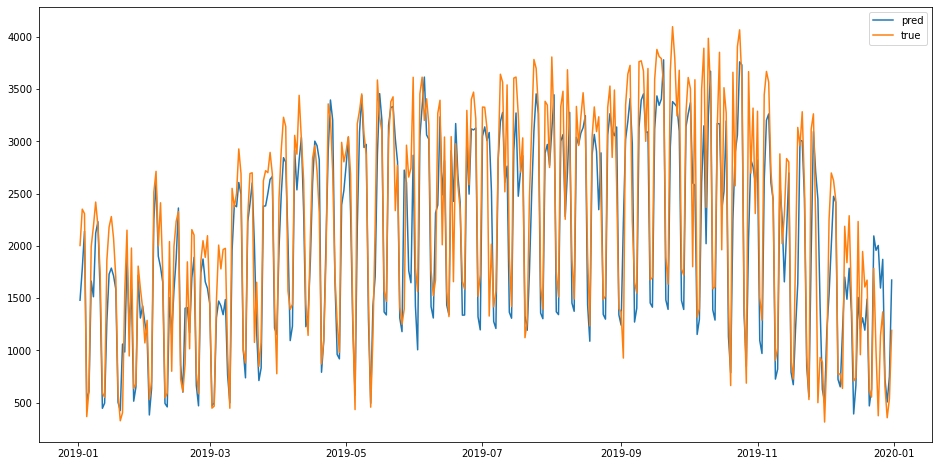

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = pd.concat([X17, X18])
y = np.concatenate([y17, y18])

# initialize the model with default parameters
model = RandomForestRegressor()
train_evaluate(model, X, y, X19, y19, data19.date.drop_duplicates().to_numpy()[N:])

dev mape: 0.18, r2: 0.81
test mape: 1.01, r2: -1.52


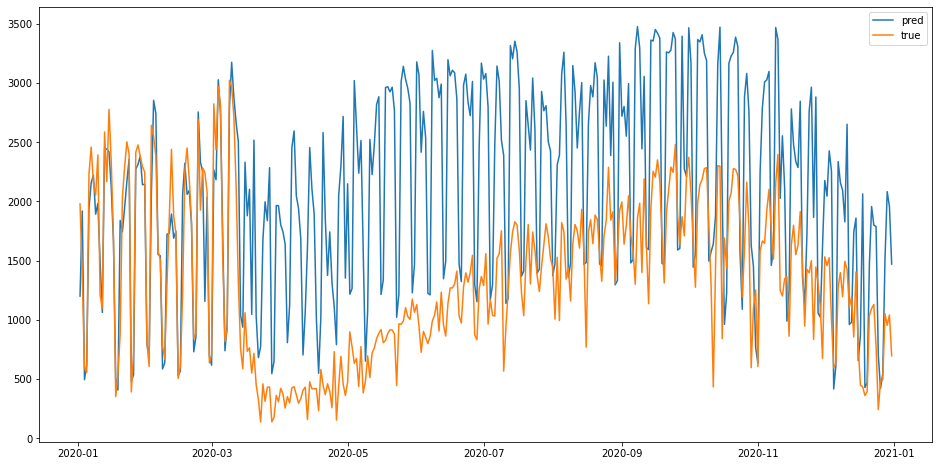

In [ ]:
X = pd.concat([X18, X19])
y = np.concatenate([y18, y19])

model = RandomForestRegressor()
train_evaluate(model, X, y, X20, y20, data20.date.drop_duplicates().to_numpy()[N:])

dev mape: 0.25, r2: 0.75
test mape: 0.22, r2: 0.76


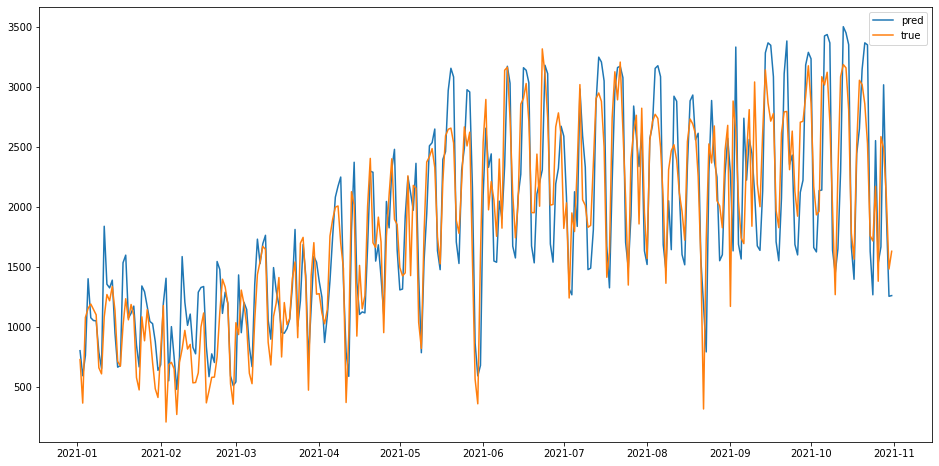

In [ ]:
X = pd.concat([X19, X20])
y = np.concatenate([y19, y20])

model = RandomForestRegressor()
train_evaluate(model, X, y, X21, y21, data21.date.drop_duplicates().to_numpy()[N:])

# Summary

1. first model: 15 today weather + 15 next day weather + 500 stations $\times$ 4 features each (d_Penn, d_GrandCentral, is_proximate, nrides)
2. 15 today weather + 15 next day weather + 10 ranges $\times$ 1 feature each (nrides)
3. (15 weather + 10 ranges $\times$ 1 feature each) $\times$ 10 days + 15 next day weather

Model 1 $\approx$ Model 2 $\Longleftrightarrow$ 2000 station features $=$ 10 ranges features

Model 3 $>$ Model 2 $\Longleftrightarrow$ more previous days used $\to$ better performance

# NN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
data = pd.concat([data17, data18, data19, data20, data21], axis=0)

data['distance'] = (data.d_Penn + data.d_GrandCentral) / 2
data.drop(columns={'is_proximate', 'd_Penn', 'd_GrandCentral'}, inplace=True)

In [ ]:
import math

intervals = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, math.inf]
data['distance_range'] = 0

for i in range(len(intervals) - 1):
    cond1 = data.distance >= intervals[i]
    cond2 = data.distance < intervals[i+1]
    data['distance_range'] += i * (cond1 & cond2)

In [ ]:
data = data.groupby(by=['date', 'distance_range']).agg({'nrides': 'sum'})
data = data.unstack('distance_range')
data.reset_index(inplace=True)

In [ ]:
cols = ['date']
for i in range(len(intervals)-1):
    cols += ['range'+str(i)]

data.columns = cols

In [ ]:
data = pd.merge(date_info, data, on='date')
data.drop(columns='date', inplace=True)

In [ ]:
data.head()

,day_of_week,is_weekend,tmax,tmin,prcp,snow,snwd,awnd,is_rain,is_snow,is_spring,is_summer,is_autumn,is_winter,is_holiday,range0,range1,range2,range3,range4,range5,range6,range7,range8,range9
0,6,1,48,40,0.00,0.0,0.0,5.59,0,0,0,0,0,1,1,423.0,1485.0,2582.0,2342.0,2016.0,1940.0,1661.0,1047.0,849.0,65.0
1,0,0,41,37,0.21,0.0,0.0,9.17,1,0,0,0,0,1,1,366.0,1052.0,1560.0,1442.0,1145.0,1013.0,978.0,656.0,591.0,30.0
2,1,0,43,39,0.58,0.0,0.0,10.74,1,0,0,0,0,1,0,851.0,2220.0,2264.0,1722.0,1439.0,1317.0,1262.0,760.0,620.0,30.0
3,2,0,52,34,0.00,0.0,0.0,8.05,0,0,0,0,0,1,0,1868.0,5092.0,5158.0,4148.0,3205.0,2860.0,2522.0,1545.0,860.0,56.0
4,3,0,34,27,0.00,0.0,0.0,7.83,0,0,0,0,0,1,0,1661.0,4405.0,4359.0,3498.0,2710.0,2423.0,2005.0,1416.0,839.0,40.0


In [ ]:
X = pd.concat([data.shift(-k) for k in range(10)], axis=1)
X = X.iloc[:-10].to_numpy()

y = data.shift(-10).iloc[:-10]
XX = y.iloc[:, :15].to_numpy()
y = y.range0.to_numpy()

X = np.concatenate([X, XX], axis=1)

In [ ]:
X_test = X[-304:]
y_test = y[-304:]

X = X[:-304]
y = y[:-304]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.25)

In [ ]:
class CitiDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
BATCH_SIZE = 20

train_loader = DataLoader(CitiDataset(X_train, y_train),
                          batch_size=BATCH_SIZE,
                          shuffle=True)
dev_loader   = DataLoader(CitiDataset(X_dev, y_dev),
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader  = DataLoader(CitiDataset(X_test, y_test),
                          batch_size=BATCH_SIZE,
                          shuffle=True)

In [ ]:
class DeepNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(25, 128),
            nn.ReLU()
        ) 

        self.rnn = nn.RNN(128, 128,
                          num_layers=1,
                          batch_first=True,
                          nonlinearity='relu')
        self.h0 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(1, 1, 128)))
        
        self.decoder = nn.Sequential(
            nn.Linear(143, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(32, 1)
        )


    def forward(self, x):
        x1 = x[:, :250].view(-1, 10, 25)
        x2 = x[:, 250:]
        x = self.encoder(x1)
        h0 = torch.cat([self.h0]*x.shape[0], dim=1)
        _, x = self.rnn(x, h0)
        x = x.squeeze()
        x = torch.cat([x, x2], dim=1)
        x = self.decoder(x)

        return x


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
def train(model, loader, optimizer, scheduler, criterion):
    model.train()

    epoch_loss = []
    epoch_mape = []

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(X)

        loss = criterion(y_pred, y)
        mape = mean_absolute_percentage_error(y_pred.detach().numpy(), y.detach().numpy())

        loss.backward()
        optimizer.step()

        epoch_loss += [loss.item()]
        epoch_mape += [mape]
    
    scheduler.step()

    return np.mean(epoch_loss), np.mean(epoch_mape)


In [ ]:
def evaluate(model, loader, criterion):
    model.eval()

    epoch_loss = []
    epoch_mape = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            mape = mean_absolute_percentage_error(y_pred.detach().numpy(), y.detach().numpy())

            epoch_loss += [loss.item()]
            epoch_mape += [mape]

    return np.mean(epoch_loss), np.mean(epoch_mape)


In [ ]:
model = DeepNet()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose=False)
criterion = F.mse_loss

In [ ]:
N_EPOCH = 30

train_loss_list, dev_loss_list = [], []

for epoch in range(N_EPOCH):
    train_loss, train_mape = train(model, train_loader, optimizer, scheduler, criterion)
    dev_loss, dev_mape = evaluate(model, dev_loader, criterion)

    train_loss_list.append(train_loss)
    dev_loss_list.append(dev_loss)

    print('[epoch %02d] train loss: %2.2f, dev loss: %2.2f, train mape: %2.2f%%, dev mape: %2.2f%%' %
          (epoch+1, train_loss, dev_loss, train_mape*100, dev_mape*100))

[epoch 01] train loss: 1815122.45, dev loss: 1378818.30, train mape: 4052.52%, dev mape: 62.77%
[epoch 02] train loss: 1621293.27, dev loss: 1292877.68, train mape: 71.85%, dev mape: 49.75%
[epoch 03] train loss: 1527600.68, dev loss: 1226178.57, train mape: 61.59%, dev mape: 45.80%
[epoch 04] train loss: 1455594.51, dev loss: 1290802.08, train mape: 56.47%, dev mape: 41.19%
[epoch 05] train loss: 1367782.65, dev loss: 1291474.18, train mape: 54.86%, dev mape: 56.13%
[epoch 06] train loss: 1370016.50, dev loss: 1082858.46, train mape: 55.94%, dev mape: 43.90%
[epoch 07] train loss: 1359818.95, dev loss: 1160276.19, train mape: 54.79%, dev mape: 51.37%
[epoch 08] train loss: 1298384.69, dev loss: 1143544.75, train mape: 52.21%, dev mape: 43.63%
[epoch 09] train loss: 1311135.70, dev loss: 1107159.22, train mape: 52.22%, dev mape: 47.67%
[epoch 10] train loss: 1328830.65, dev loss: 1145097.64, train mape: 52.71%, dev mape: 49.98%
[epoch 11] train loss: 1289996.04, dev loss: 1118107.55, t

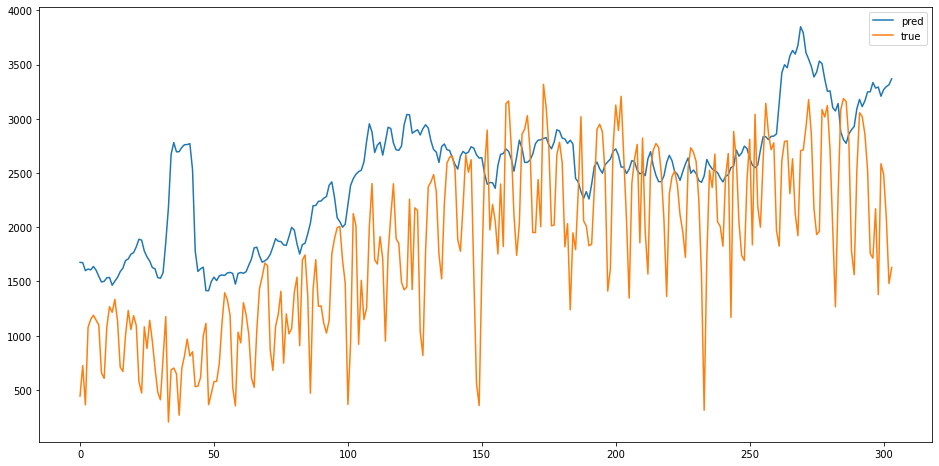

In [ ]:
with torch.no_grad():
    y_test_pred = model(torch.tensor(X_test, dtype=torch.float))

y_test_pred = y_test_pred.flatten().numpy()

plt.figure(figsize=[16, 8])
plt.plot(y_test_pred, label='pred')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

# END